In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 250
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_40ms.npy")
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/V_na_true_0.4ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_40ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    #V_pad = np.zeros_like(V)
    #V_pad[:,i+1:] = V[:,:-i-1]
    #V_lag[:,:,i] = V - V_pad
    
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 250, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []


for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-b35bec30f1f9>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.6150280833244324
49 0.06906560808420181
99 0.046860113739967346
149 0.04015417397022247
199 0.03578949347138405
249 0.0323287695646286
299 0.029500557109713554
349 0.02607881650328636
399 0.02433905564248562
449 0.023281611502170563
499 0.021940452978014946
549 0.020618872717022896
599 0.01980874314904213
649 0.019777515903115273
699 0.019542135298252106
749 0.019304469227790833
799 0.018784381449222565
849 0.01874247007071972
899 0.018068324774503708
949 0.01844056136906147
999 0.018240908160805702
1049 0.01797076128423214
1099 0.01762906089425087
1149 0.017915213480591774
1199 0.017345132306218147
1249 0.017271030694246292
1299 0.01765318587422371
1349 0.018016066402196884
1399 0.018085939809679985
1449 0.01793188787996769
1499 0.017723888158798218
1549 0.01786079816520214
1599 0.018019458279013634
1649 0.01752656325697899
1699 0.017614949494600296
1749 0.01827235333621502
1799 0.017217403277754784
1849 0.017539391294121742
1899 0.017665261402726173
1949 0.01767650619149208
1999 

KeyboardInterrupt: 

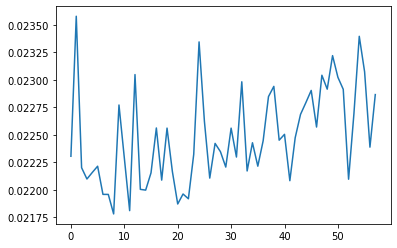

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.9966, device='cuda:0', grad_fn=<MaxBackward1>)


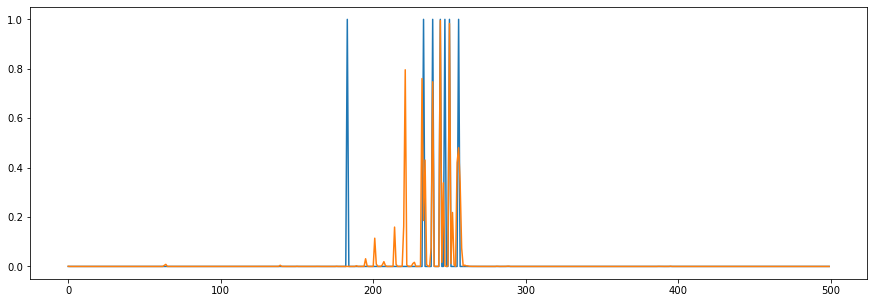

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [7]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_40ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_40ms_test.npy", test_S_out.cpu().detach().numpy())